# Step 7: Fit a nonrigid transformation

In [1]:
import os
import numpy as np
from functools import partial
from skimage.external import tifffile
from phathom.registration import registration as reg
from phathom import plotting
from phathom import io
from phathom.utils import pickle_save, pickle_load, read_voxel_size

In [2]:
working_dir = '/media/jswaney/Drive/Justin/marmoset/'
# working_dir = '/media/jswaney/Drive/Justin/coregistration/whole_brain_tde'
voxel_size = read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))

In [3]:
# Load the affine transformation
affine_path = 'affine_transformation.pkl'

affine_transformation = pickle_load(os.path.join(working_dir, 
                                                 affine_path))

In [4]:
# Load the matching coordinates
fixed_keypts_path = 'fixed_keypts.npy'
affine_keypts_path = 'affine_keypts.npy'
moving_keypts_path = 'moving_keypts.npy'

fixed_keypts = np.load(os.path.join(working_dir, fixed_keypts_path))
affine_keypts = np.load(os.path.join(working_dir, affine_keypts_path))
moving_keypts = np.load(os.path.join(working_dir, moving_keypts_path))

print(fixed_keypts.shape)

(8921, 3)


In [21]:
nb_samples = 8921

idx = np.random.choice(np.arange(fixed_keypts.shape[0]),
                       nb_samples, 
                       replace=False)

fixed_sample = fixed_keypts[idx]
affine_sample = affine_keypts[idx]
moving_sample = moving_keypts[idx]

In [22]:
# Fit the thin-plate spline
smooth = 10

rbf_z, rbf_y, rbf_x = reg.fit_rbf(affine_sample, 
                                  moving_sample, 
                                  smooth)

In [23]:
# Make the 3D TPS transformation
tps_transform = partial(reg.rbf_transform,
                        rbf_z=rbf_z, 
                        rbf_y=rbf_y, 
                        rbf_x=rbf_x)

In [24]:
# Apply the thin-plate spline warp on the affine keypts
nonrigid_keypts = tps_transform(affine_keypts)

In [9]:
# Save the TPS-warped keypts for reference
nonrigid_keypts_path = 'nonrigid_keypts.npy'

np.save(os.path.join(working_dir, nonrigid_keypts_path), nonrigid_keypts)

In [5]:
# Load nonrigid keypts if alreadyt warped
nonrigid_keypts_path = 'nonrigid_keypts.npy'

nonrigid_keypts = np.load(os.path.join(working_dir, nonrigid_keypts_path))

In [25]:
# Convert to um
fixed_keypts_um = fixed_keypts * np.asarray(voxel_size)
nonrigid_keypts_um = nonrigid_keypts * np.asarray(voxel_size)
moving_keypts_um = moving_keypts * np.asarray(voxel_size)

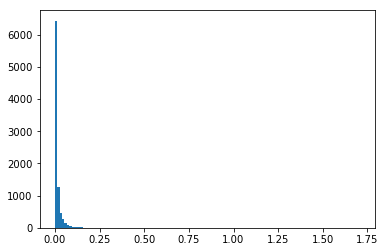

Nonrigid ave. distance [um]: 0.0160978597953


In [26]:
# Show residuals after thin-plate spline
nonrigid_residuals = reg.match_distance(nonrigid_keypts_um,
                                        moving_keypts_um)
plotting.plot_hist(nonrigid_residuals, 128)
print('Nonrigid ave. distance [um]:', nonrigid_residuals.mean())

In [8]:
# Aside: save residuals
import pandas as pd

In [9]:
df = pd.DataFrame({'tps': nonrigid_residuals})
df.to_excel(os.path.join(working_dir, 'tps_residuals.xlsx'))

In [12]:
# Make a nonrigid mapping from fixed to moving coordinates
nonrigid_transform = partial(reg.nonrigid_transform,
                             affine_transform=affine_transformation, 
                             rbf_z=rbf_z, 
                             rbf_y=rbf_y, 
                             rbf_x=rbf_x)

In [13]:
# Save the nonrigid transformation
nonrigid_path = 'nonrigid_transformation.pkl'

pickle_save(os.path.join(working_dir, nonrigid_path), nonrigid_transform)

In [14]:
# Open images
fixed_zarr_path = 'round1/syto16.zarr/1_1_1'
moving_zarr_path = 'round2/syto16.zarr/1_1_1'

fixed_img = io.zarr.open(os.path.join(working_dir,
                                      fixed_zarr_path), 
                         mode='r')
moving_img = io.zarr.open(os.path.join(working_dir,
                                       moving_zarr_path), 
                          mode='r')

In [38]:
# Warp a regular grid with exact TPS
nb_pts = 100

z = np.linspace(0, fixed_img.shape[0], nb_pts)
y = np.linspace(0, fixed_img.shape[1], nb_pts)
x = np.linspace(0, fixed_img.shape[2], nb_pts)
# values = reg.warp_regular_grid(nb_pts, z, y, x, nonrigid_transform)

In [16]:
# Save the grid values
np.save(os.path.join(working_dir, 'grid_values.npy'), values)

In [39]:
# Load grid values if already computed
values = np.load(os.path.join(working_dir, 'grid_values.npy'))

In [40]:
# Fit a RegularGridInterpolator
grid_interp = reg.fit_grid_interpolator(z, y, x, values)

In [41]:
# Fit a MapCoordinatesInterpolator
map_interp = reg.fit_map_interpolator(values, fixed_img.shape, order=1)

In [42]:
# Wrap the z,y,x interpolators together
grid_interpolator = partial(reg.interpolator, interp=grid_interp)
map_interpolator = partial(reg.interpolator, interp=map_interp)

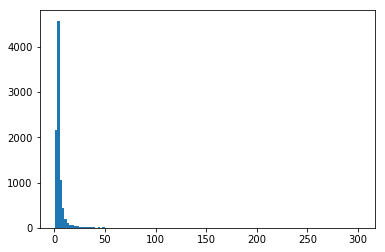

Interpolator ave. distance [um]: 5.67815926727


In [43]:
# Show residuals after interpolator
interp_keypts = map_interpolator(pts=fixed_keypts)
interp_keypts_um = interp_keypts * np.asarray(voxel_size)
interp_residuals = reg.match_distance(interp_keypts_um,
                                      moving_keypts_um)
plotting.plot_hist(interp_residuals, 128)
print('Interpolator ave. distance [um]:', interp_residuals.mean())

In [21]:
# Register a single slice to preview the result
zslice = 200
batch_size = 10000
padding = 4

reg_slice = reg.register_slice(moving_img,
                               zslice=zslice,
                               output_shape=fixed_img.shape[1:],
                               transformation=affine_transformation,
                               batch_size=batch_size,
                               padding=padding)
fixed_slice = fixed_img[zslice]

100%|██████████| 6563/6563 [00:05<00:00, 1141.43it/s]


(0, 0, 0) (1793, 9017, 5529)


MemoryError: 

In [55]:
moving_slice = moving_img[zslice]

<IPython.core.display.Javascript object>


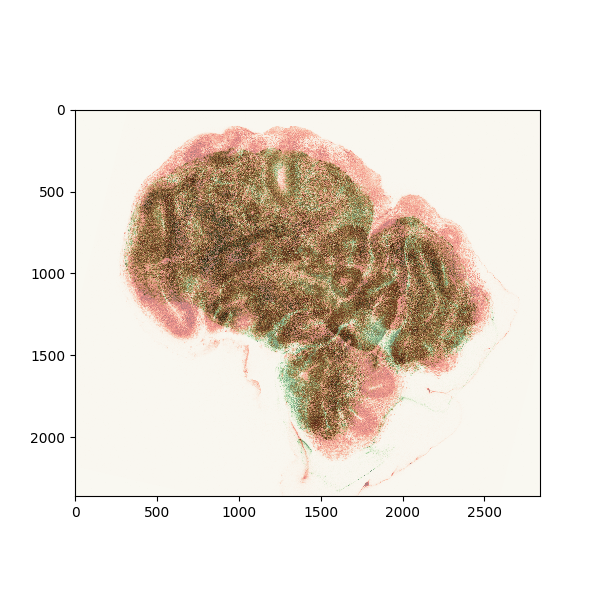

In [82]:
%matplotlib notebook
# Show an overlay of the registered and fixed slices
fixed_clim = [0, 3000]
reg_clim = [0, 3000]
figsize = (6, 6)

plotting.plot_overlay(fixed_slice, 
                      reg_slice, 
                      fixed_clim, 
                      reg_clim, 
                      figsize)

In [37]:
# Save the registered and fixed slice
fixed_slice_path = 'fixed_slice.tif'
moving_slice_path = 'moving_slice.tif'
reg_slice_path = 'registered_slice.tif'

tifffile.imsave(os.path.join(working_dir, fixed_slice_path), 
                fixed_slice)
tifffile.imsave(os.path.join(working_dir, moving_slice_path), 
                moving_slice)
tifffile.imsave(os.path.join(working_dir, reg_slice_path), 
                reg_slice)

In [44]:
# Save the grid_interpolator
interpolator_path = 'grid_interpolator.pkl'

pickle_save(os.path.join(working_dir, interpolator_path), 
            grid_interpolator)

In [45]:
# Save the map_interpolator
interpolator_path = 'map_interpolator.pkl'

pickle_save(os.path.join(working_dir, interpolator_path), 
            map_interpolator)